# Gaussian Process Regression (v1)
In this notebook, we consider the process of regression using Gaussian processes. We initially fit a Gaussian process to a set of data-points assuming no measurement noise. In this context, we consider a parameter in the kernel, $\lambda$, and the effect of this parameter on the goodness-of-fit.

We then consider an example, where we fit to noisy measurements. In this context, we introduce a variance to the model, $\sigma$, and the effect of this parameter on the uncertainty of the model.

Finally, we consider parameter estimation in Gaussian processes using maximum likelihood estimation.

In [90]:
""" Imports """
from cvxopt import matrix, spmatrix, exp, sin, cos, sqrt, min
import numpy as np
import matplotlib.pyplot as plt

## Kernel Function
In this notebook, we consider the squared exponential kernel. The kernel is defined as

$$
    k(x,y) = \frac{1}{2 \lambda^2} e^{ - \frac{1}{2} \| x - y \|^2 }
$$

The kernel is a measure of similarity. We use the kernel to estimate the variance and co-variance between points. The squared exponential kernel is constructed in such a way, the points close to each other have high correlation ($1$ if they are identical) and points far appart have low correlation ($0$ for the distance going to $\infty$).

In [91]:
""" Gaussian Process Functions """
## Similarty Measure - Squares exponential kernel
def k( x, y, lambda_=1.0 ):
    x = matrix(x)
    y = matrix(y)
    xmy = x - y
    return exp( -1/(2*lambda_**2)*xmy.T*xmy )

## Test 'k'-function
try:
    k( 0.0, 0.0 )
except:
    print( 'Kernel error.' )

## Data Generation
We generate a set of data-point, with no noise, over an interal from $-5$ to $5$, as the sine of these points.

In [92]:
""" Generate Data Points """
def generate_data( xmin, xmax, N, outfun=lambda x: 0.0*x, noise=0.0 ):
    ## Data space
    xint = xmax - xmin
    x    = (matrix( range(N+1) )/N)*xint - 0.5*xint
    
    ## Output data
    e_k = matrix(sqrt( noise ) * np.random.randn(N,1))
    y_true = outfun( x )
    y      = y_true + e_k
    
    ## Return statement
    return x, y, y_true


## Test 'generate_data'-function
try:
    _, _, _ = generate_data( 0.0, 1.0, 100 )
except:
    print( 'Data generation error.' )


## Define boundaries and grid
xmin = -5
xmax = 5
N    = 100

## Generate Data
X    = generate_data(xmin,xmax,N)
Y    = sin(X)

## Training the Gaussian Process
We define a subset of the generated data for training, define a prior (starting with a zero-mean prior) and compute the co-variaince matrix using the simularity measure (the squared exponential kernel).

In [93]:
## Training Data
x_id = [0,1,2,30,40,50,60,70,71,72,100]
#x_id = [5, 30, 42, 65, 78, 90]
x    = X[x_id]
y    = Y[x_id]


""" Compute Mean and Co-variance """
def prior( x ):
    x = matrix(x)
    return matrix( 0.0, x.size )
    #return sin(x) + cos(x)


## Test 'prior'-function
try:
    _ = prior( 0.0 )
except:
    print( 'Prior error.' )

    
## Generate Gaussian process for lambda_1 - GP_1
mu_1    = matrix( prior(x) )
lambda_1   = 0.5
Sigma_1 = matrix( 0.0, (y.size[0],y.size[0]))
for i in range(y.size[0]):
    for j in range(i,y.size[0]):
        co_var     = k( x[i], x[j], lambda_1 )
        Sigma_1[i,j] = co_var
        Sigma_1[j,i] = co_var
        
        
## Generate Gaussian process for lambda_2 - GP_2
mu_2    = matrix( prior(x) )
lambda_2   = 1.0
Sigma_2 = matrix( 0.0, (y.size[0],y.size[0]))
for i in range(y.size[0]):
    for j in range(i,y.size[0]):
        co_var     = k( x[i], x[j], lambda_2 )
        Sigma_2[i,j] = co_var
        Sigma_2[j,i] = co_var

In [94]:
""" Prediction Method """
def predict( x_, prior=prior, mu=mu_1, Sigma=Sigma_1, lambda_=lambda_1, beta=1.0, sigma=0.0 ):
    ## Type-check y
    x_ = matrix(x_)
    I_x  = matrix( spmatrix( 1.0, range(mu.size[0]), range(mu.size[0]) ) )
    I_x_ = matrix( spmatrix( 1.0, range(x_.size[0]), range(x_.size[0]) ) )
    
    ## Pre-allocate
    K_xx_  = matrix( 0.0, (x.size[0],x_.size[0]) )
    K_x_x_ = matrix( 0.0, (x_.size[0],x_.size[0]) )
    
    ## Compute Co-variances
    for i in range(x.size[0]):
        for j in range(x_.size[0]):
            K_xx_[i,j] = k( x[i], x_[j], lambda_=lambda_ )
            
    for i in range(x_.size[0]):
        for j in range(x_.size[0]):
            K_x_x_[i,j] = k( x_[i], x_[j], lambda_=lambda_ )
            
    ## Prediction
    Sigma_inv = matrix( np.linalg.inv(Sigma + sigma*I_x) )
    mu_x_    = prior(x_)*beta + K_xx_.T*Sigma_inv*(y - mu*beta)
    Sigma_x_ = K_x_x_ + sigma*I_x_ + sigma - K_xx_.T*Sigma_inv*K_xx_
    
    return mu_x_, Sigma_x_


## Test 'predict'-function
try:
    mu_x_, Sigma_x_ = predict( 0.0 )
except:
    print( 'Prediction error.' )

In [95]:
""" Prediction using Gaussian Process Fit """
#(X,Y) are the true data points

Y_1_pred     = matrix( 0.0, (Y.size[0],1) )
Sigma_1_pred = matrix( 0.0, (Y.size[0],1) )
Y_2_pred     = matrix( 0.0, (Y.size[0],1) )
Sigma_2_pred = matrix( 0.0, (Y.size[0],1) )
for i in range(X.size[0]):
    Y_1_pred[i], Sigma_1_pred[i] = predict( X[i], mu=mu_1, Sigma=Sigma_1, lambda_=lambda_1 )
    Y_2_pred[i], Sigma_2_pred[i] = predict( X[i], mu=mu_2, Sigma=Sigma_2, lambda_=lambda_2 )

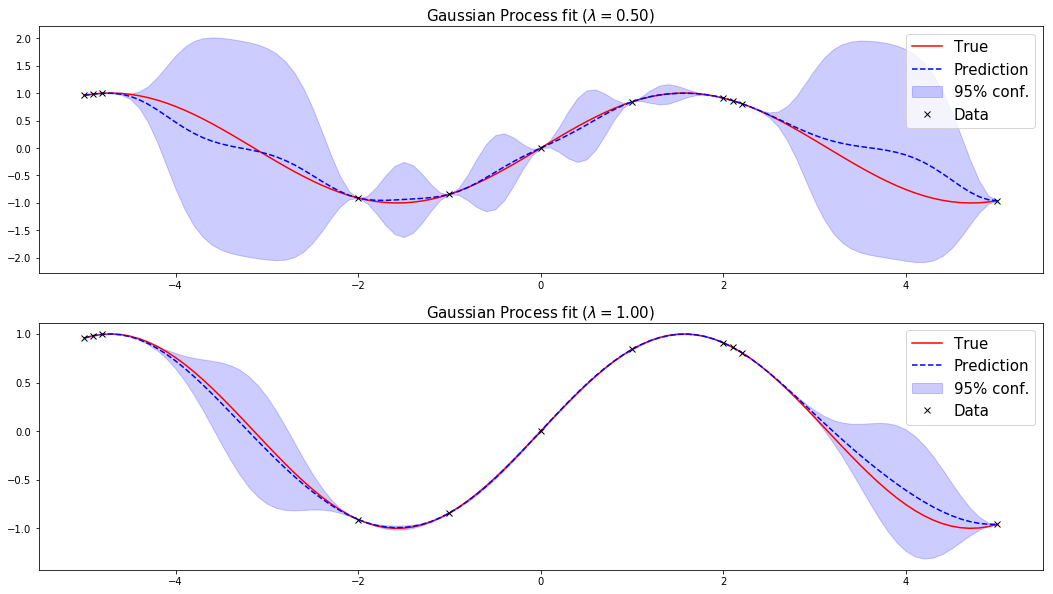

In [96]:
""" Visualisation """
fontsize = 15

fig, ax = plt.subplots( nrows=2, figsize=(18,10) )

## Fit for tau_1
ax[0].set_title('Gaussian Process fit ($\lambda = %.2f$)' % lambda_1, fontsize=fontsize )

p = [None]*4
p[0], = ax[0].plot( X, Y, 'r-', label='True' )

X_fill = np.array(X).reshape(X.size[0],)
Yu_fill = np.array(Y_1_pred + 1.96*Sigma_1_pred).reshape(X.size[0],)
Yl_fill = np.array(Y_1_pred - 1.96*Sigma_1_pred).reshape(X.size[0],)
p[2] = ax[0].fill_between( X_fill, Yl_fill, Yu_fill, color='blue', alpha=0.2, label='95% conf.' )
p[1], = ax[0].plot( X, Y_1_pred, 'b--', label='Prediction' )
p[3], = ax[0].plot( x, y, 'kx', label='Data')
ax[0].legend( handles=p, fontsize=fontsize )


## Fit for tau_2
ax[1].set_title('Gaussian Process fit ($\lambda = %.2f$)' % lambda_2, fontsize=fontsize )

p = [None]*4
p[0], = ax[1].plot( X, Y, 'r-', label='True' )

X_fill = np.array(X).reshape(X.size[0],)
Yu_fill = np.array(Y_2_pred + 1.96*Sigma_2_pred).reshape(X.size[0],)
Yl_fill = np.array(Y_2_pred - 1.96*Sigma_2_pred).reshape(X.size[0],)
p[1], = ax[1].plot( X, Y_2_pred, 'b--', label='Prediction' )
p[2] = ax[1].fill_between( X_fill, Yl_fill, Yu_fill, color='blue', alpha=0.2, label='95% conf.' )
p[3], = ax[1].plot( x, y, 'kx', label='Data')
ax[1].legend( handles=p, fontsize=fontsize )
plt.show()

## Maximum Likelihood Estimation

In [99]:
""" Closed-form Maximum Likelihood Expression for beta and sigma """
def ml_beta_sigma( y, mu, Sigma ):
    ## ML estimate of beta
    Sigma_inv = matrix(np.linalg.inv(Sigma))
    tmp       = mu.T*Sigma_inv*mu
    
    if min(tmp) > 0.0:
        tmp_inv   = matrix(np.linalg.inv(mu.T*Sigma_inv*mu))
    else:
        tmp_inv = matrix( 0.0, (mu.size[1],1) )
        
    beta_ml   = tmp_inv*mu.T*Sigma*y
    
    ## ML estimate of sigma
    sigma_ml = sqrt( ( ( y - mu*beta_ml ).T*Sigma_inv*( y - mu*beta_ml ) )/y.size[0] )
    
    return beta_ml, sigma_ml

## Compute estimates
beta_1_ml, sigma_1_ml = ml_beta_sigma( y, mu_1, Sigma_1 )
beta_2_ml, sigma_2_ml = ml_beta_sigma( y, mu_2, Sigma_2 )
print( beta_1_ml, beta_2_ml )
print( sigma_1_ml, sigma_2_ml )

[ 0.00e+00]
 [ 0.00e+00]

[ 6.69e-01]
 [ 6.04e-01]



In [101]:
evs = np.linalg.inv(Sigma_1)
print( np.min(evs[0]) )

-637.5408275404473
